<a href="https://colab.research.google.com/github/Patorden/patoorden/blob/main/Potencial_de_captaci%C3%B3n_por_vivienda_promedio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Este es el código de la función
- presiona el botón de play abajo ó dale shft + enter

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Código básico

In [14]:
pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=8ba2f57b6096119ef2f7ea296e9f23e32fb9f07ffba350f545b1da78c3efed3c
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [15]:
def obtener_autonomia_hidrica(directorio_precip, area_techo_prom, consumo_diario_prom, habitantes_casa_prom, factor_perdida,
                              volumen_tinaco, volumen_separador, meses_no_capt, nombre_beneficiario, apellido_p_beneficiario,
                              apellido_m_beneficiario, costo_prom_litro):

    import pandas as pd
    import numpy as np
    from fpdf import FPDF


    precipitacion = pd.read_csv(directorio_precip)    # leemos el CSV de precipitación diaria

    precipitacion['id'] = (precipitacion['Mes'].astype(str).apply('{:0>2}'.format)     # creamos un id único para cada día del año
                           +
                           precipitacion['Día'].astype(str).apply('{:0>2}'.format))

    precipitacion_sinnan = precipitacion.dropna(how = 'any')    # quitamos valores nulos

    df = pd.DataFrame(precipitacion_sinnan.groupby('id')[['Datos','Mes','Día']].mean())    # generamos una tabla que calcula el promedio de los valores únicos
                                                                                           # osea que calcule cunato llueve cada día del año en promedio

    df = df.rename(columns = {'Datos': 'precip_diaria_promedio'}) # Le cambiamos el nombre a la columna para tener menos confución

    df['Mes'] = df['Mes'].astype(int)
    df['Mes'] = df['Mes'].astype(str)
    df['Día'] = df['Día'].astype(str)
    meses_dias = {'1': 'Ene', '2': 'Feb', '3': 'Mar', '4': 'Abr',
                  '5': 'May', '6': 'Jun', '7': 'Jul', '8': 'Ago',
                  '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dic'}  # Cambiamos el número de mes al nombre del mes
    df['Mes'].replace(meses_dias, inplace=True)

    df['Mes_Día'] = df['Mes'] + '-' + df['Día'] +'-22' # le  agregamos el año del 2022 sólo para poder agregar otro año con 2023 después



    df['litros_captados_diarios'] = 0.0    # Creamos una nueva columna vacía

    for i in range(0,len(df)):                          # calculamos el volumen captado de agua por día
        captacion = (df['precip_diaria_promedio'][i] *
                     area_techo_prom) * factor_perdida

        if captacion <= volumen_separador:          # si no se llena el separador de primeras lluvias
            df['litros_captados_diarios'][i] = 0.0; # no se cuenta los litros captados
        else:
            df['litros_captados_diarios'][i] = captacion - volumen_separador;

    for i in range(0,len(df)):  #Ahora le indicamos que no cuente el agua captada ciertos meses:
        if df['Mes'][i] in meses_no_capt:
            df['litros_captados_diarios'][i] = 0.0

    df['uso_total_por_vivienda'] = habitantes_casa_prom * consumo_diario_prom # Calculamos el consumo total diario por vivienda

    df_abril_1 = df.loc['0401':'1231']     # partimos la table en dos para que comienze en la temporada de lluvias
    df_enero_1 = df.loc['0101':'0331']

    df = df_abril_1.append(df_enero_1)

    df2 = df_abril_1.append(df_enero_1)                   # creamos un segundo año, ya que nos servirá para ver cuanta
    df2['Mes_Día'] = df2['Mes'] + '-' + df2['Día'] +'-23' # autonomía puede tener una familia en la temporada seca:
    df = df.append(df2)

    df['litros_abastecidos'] = 0.0
    for i in range (1,len(df)):                           # calculamos el agua que se almacena cada día
        litros_disp = ((df['litros_captados_diarios'][i] - # esto almacena lo que se capta durante el día
                       df['uso_total_por_vivienda'][i]) + # menos el consumo diario de la familia durante el día
                       df['litros_abastecidos'][i-1])      # más lo almacenado del día anterior
        if litros_disp < 0:
            df['litros_abastecidos'][i] = 0.0             # que no baje del 0 ó no haya reservas negativas (<0)
        elif litros_disp > volumen_tinaco:
            df['litros_abastecidos'][i] = volumen_tinaco  # y que no se almacene más del volumne del tinaco
        else:
            df['litros_abastecidos'][i] = litros_disp

    anio_1 = df[0:365]             # Creamos una serie de textos con resultados
    anio_2 = df[366:len(df)-1]

    dias_autonomia_hidrica_anio_1 = anio_1['litros_abastecidos'][anio_1['litros_abastecidos'] > 120].count()
    num_dias_sin_agua_anio_1 = anio_1['litros_abastecidos'][anio_1['litros_abastecidos'] < 120].count()
    dias_sin_agua_anio_1 = anio_1[anio_1['litros_abastecidos'] > 120]
    dias_autonomia_hidrica_anio_2 = anio_2['litros_abastecidos'][anio_2['litros_abastecidos'] > 120].count()
    num_dias_sin_agua_anio_2 = anio_2['litros_abastecidos'][anio_2['litros_abastecidos'] < 120].count()
    dias_sin_agua_anio_2 = anio_2[anio_2['litros_abastecidos'] > 120]

    resumen_texto = f'''    ---------------------Primer Año---------------------
    - Días de autonomía hídrica el primer año: {dias_autonomia_hidrica_anio_1} días
    - Días sin agua del primer año: {num_dias_sin_agua_anio_1} días
    - Porcentaje de días con autonomía Hídrica: {round((dias_autonomia_hidrica_anio_1/365)*100,2)}%
    - Cantidad de agua abastecida el primer año: {dias_autonomia_hidrica_anio_1 * (consumo_diario_prom  * habitantes_casa_prom)} litros
    - Litros faltantes el primer año: {num_dias_sin_agua_anio_1 * (consumo_diario_prom  * habitantes_casa_prom)} litros
    - Costo total de agua ahorrado el primer año: {round((dias_autonomia_hidrica_anio_1 * (consumo_diario_prom  * habitantes_casa_prom))* costo_prom_litro, 2)} pesos

    ---------------------Segundo Año en adelante---------------------
    - Días de autonomía Hídrica el segundo año: {dias_autonomia_hidrica_anio_2} días
    - Días sin agua del segundo año: {num_dias_sin_agua_anio_2} días
    - Porcentaje de días con autonomía Hídrica: {round((dias_autonomia_hidrica_anio_2/365)*100,2)}%
    - Cantidad de agua abastecida el segundo año: {dias_autonomia_hidrica_anio_2 * (consumo_diario_prom  * habitantes_casa_prom)} litros
    - Litros faltantes el segundo año: {num_dias_sin_agua_anio_2 * (consumo_diario_prom  * habitantes_casa_prom)} litros
    - Costo total de agua ahorrado el primer año: {round((dias_autonomia_hidrica_anio_2 * (consumo_diario_prom  * habitantes_casa_prom))* costo_prom_litro, 2)} pesos
    '''

    import matplotlib.pyplot as plt     # creamos la gráfica:

    font = {'family': 'Helvetica Neue',
            'color':  'black',
            'weight': 'regular',
            'size': 15,
            }

    fig, ax1 = plt.subplots()
    fig.set_size_inches(18.5, 8)
    plt.style.use('seaborn')

    myDates = df['Mes_Día']
    myValues = df['litros_abastecidos']

    ax1.plot(myDates, myValues, 'g', linewidth=4, label=f'Litros captados con {volumen_tinaco} litros de almacenamiento')
    #plt.fill(myDates, myValues, 'r', alpha=0.5)
    ax1.set_xlabel('Época del Año',fontdict=font)

    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Litros captados, L', fontdict=font,color='g')
    ax1.tick_params('y', direction='out')

    ax2 = ax1.twinx()
    myRain = df['precip_diaria_promedio']

    ax2.plot(myDates, myRain,color='b', label= 'Precipitación diaria', marker='o', markerfacecolor='blue', markersize=2)
    ax2.set_ylabel('Precipitación diaria, mm', fontdict=font, color='b')
    ax2.tick_params('y', labelsize= 'large')

    tick_values = [0,30,61,91, 122, 153, 183, 214,244,275,306,335,
                   0+366,30+366,61+366,91+366, 122+366, 153+366,
                   183+366, 214+366,244+366,275+366,306+366,335+366]

    labels = np.concatenate((df['Mes'].unique(), df['Mes'].unique()))

    plt.xticks(myDates[tick_values], labels)

    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95), shadow=True, ncol=2, )

    fig.savefig('graph.png')
    #ax2.legend(loc='upper left', frameon=False)

    #plt.axvline(x=0, color = 'red', alpha = 0.5)

    #pdf = FPDF()
    from fpdf import FPDF

    # Instantiation of inherited class
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font('Helvetica', 'B', size = 20)
    pdf.cell(200, 10, txt = 'Reporte de los Beneficios del Abastecimiento', ln = 1, align = 'C')
    pdf.cell(200, 10, txt = 'de Agua de Lluvia', ln = 2, align = 'C')
    pdf.set_font('Helvetica', size = 16)
    pdf.cell(200, 10, txt = f'Familia {apellido_p_beneficiario} {apellido_m_beneficiario}', ln = 3, align = 'L')
    pdf.cell(200, 10, txt = f'Propietario del sistema: {nombre_beneficiario} {apellido_p_beneficiario} {apellido_m_beneficiario}', ln = 3, align = 'L')
    pdf.set_font('Helvetica', size = 14)
    pdf.cell(200, 10, txt = '---------------------Primer Año---------------------', ln = 4, align = 'L')
    pdf.set_font('Helvetica', size = 12)
    pdf.cell(200, 5, txt = f'Días de autonomía hídrica: {dias_autonomia_hidrica_anio_1} días', ln = 5, align = 'L')
    pdf.cell(200, 5, txt = f'Días sin agua: {num_dias_sin_agua_anio_1} días', ln = 5, align = 'L')
    pdf.cell(200, 5, txt = f'Porcentaje de días con autonomía Hídrica: {round((dias_autonomia_hidrica_anio_1/365)*100,2)}%', ln = 5, align = 'L')
    pdf.cell(200, 5, txt = f'Cantidad de agua abastecida: {dias_autonomia_hidrica_anio_1 * (consumo_diario_prom  * habitantes_casa_prom)} litros', ln = 5, align = 'L')
    pdf.cell(200, 5, txt = f'Litros faltantes: {num_dias_sin_agua_anio_1 * (consumo_diario_prom  * habitantes_casa_prom)} litros', ln = 5, align = 'L')
    pdf.cell(200, 5, txt = f'Costo total de agua ahorrado: {round((dias_autonomia_hidrica_anio_1 * (consumo_diario_prom  * habitantes_casa_prom))* costo_prom_litro, 0)} pesos', ln = 5, align = 'L')

    pdf.set_font('Helvetica', size = 14)
    pdf.cell(200, 10, txt = '---------------------Segundo año en adelante---------------------', ln = 6, align = 'L')
    pdf.set_font('Helvetica', size = 12)
    pdf.cell(200, 5, txt = f'Días de autonomía Hídrica: {dias_autonomia_hidrica_anio_2} días', ln = 7, align = 'L')
    pdf.cell(200, 5, txt = f'Días sin agua: {num_dias_sin_agua_anio_2} días', ln = 7, align = 'L')
    pdf.cell(200, 5, txt = f'Porcentaje de días con autonomía Hídrica: {round((dias_autonomia_hidrica_anio_2/365)*100,2)}%', ln = 7, align = 'L')
    pdf.cell(200, 5, txt = f'Cantidad de agua abastecida: {dias_autonomia_hidrica_anio_2 * (consumo_diario_prom  * habitantes_casa_prom)} litros', ln = 7, align = 'L')
    pdf.cell(200, 5, txt = f'Litros faltantes: {num_dias_sin_agua_anio_2 * (consumo_diario_prom  * habitantes_casa_prom)} litros', ln = 7, align = 'L')
    pdf.cell(200, 5, txt = f'Costo total de agua ahorrado: {round((dias_autonomia_hidrica_anio_2 * (consumo_diario_prom  * habitantes_casa_prom))* costo_prom_litro, 0)} pesos', ln = 7, align = 'L')

    pdf.image('/content/graph.png', w=200, h=100)
    pdf.output(f"sistema_familia_{apellido_p_beneficiario}_{apellido_m_beneficiario}.pdf")

    return fig,resumen_texto, df

### Aquí se cambian las variables que el usuario puede cambiar


<ipython-input-15-ffb926e5e114>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['litros_captados_diarios'][i] = 0.0; # no se cuenta los litros captados
<ipython-input-15-ffb926e5e114>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['litros_captados_diarios'][i] = captacion - volumen_separador;
<ipython-input-15-ffb926e5e114>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['litros_captados_diarios'][i] = 0.0
<ipython-inpu

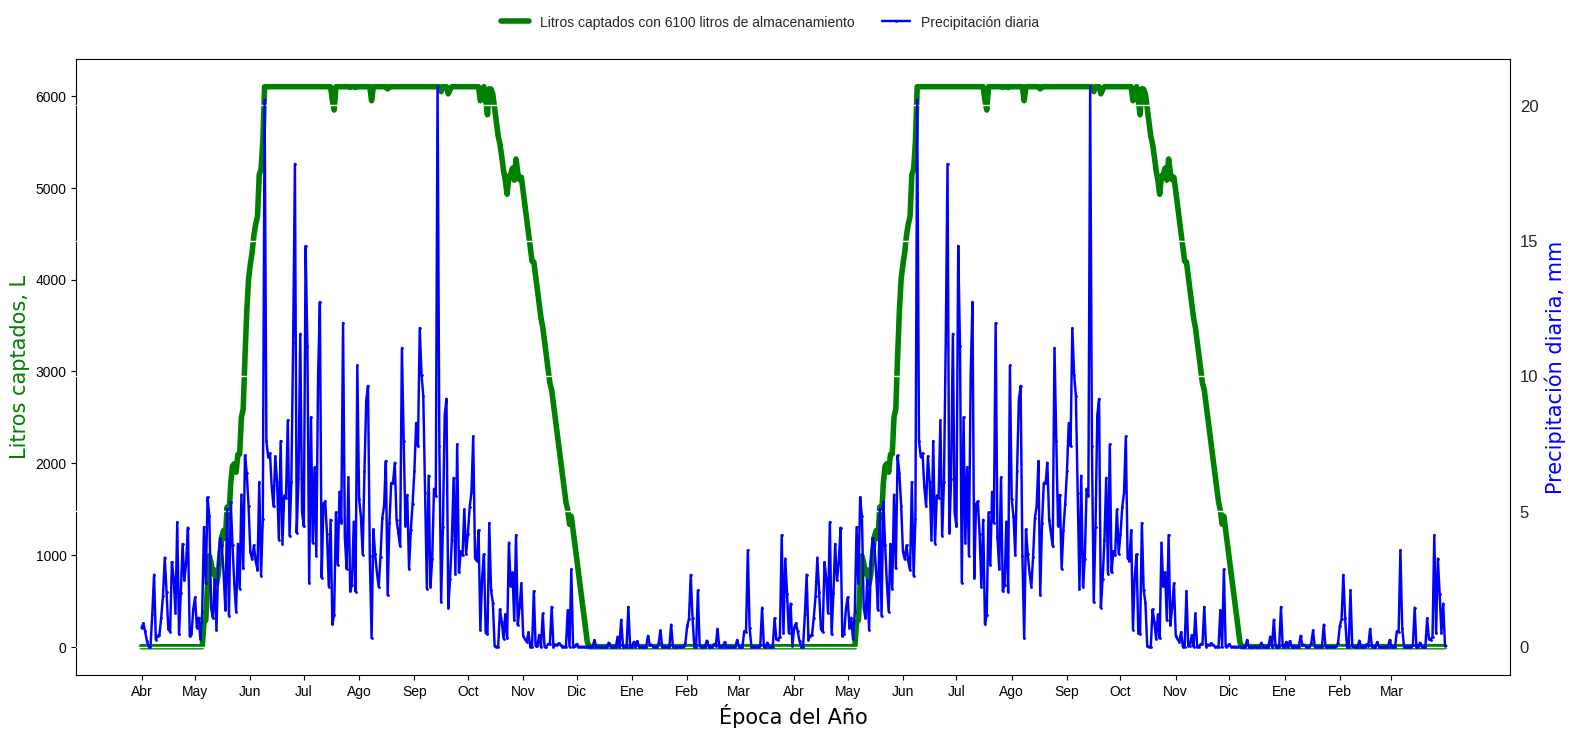

In [16]:
# nombre,             num_personas, area_capt, capacidad, duración_almacenamiento_dias, uso_prom_diario_persona
# Paloma Terán Villegas,         4, 35,  6100,  20, 76.25
# Guadalupe Cervantes Terán,     4, 128, 12200, 30, 101.67
# Ana Lilia Alvarado Alvarado,   4, 40,  3200,  10, 80
# Luis Fernando Alvarado CUevas, 4, 45,  460,   2,  57.5

directorio_precip = '/content/drive/MyDrive/Isla Urbana Geo/Proyectos de mapeo/Santa María Zegache/Datos/20266-SAN PABLO HUIXTEPEC-OAX-Precip_arreglado.csv' # directorio del CSV de precipitación
area_techo_prom = 135 # área del techo en m2
volumen_separador = int(area_techo_prom * .67)# separador rural .67, separador urbano 1.5
consumo_diario_prom = 76.25 # per cápita en litros
habitantes_casa_prom = 2 # número de personas por casa
factor_perdida = 0.85 # cuanto porcentaje de agua se capta, generalmente es el 85% o 0.85
volumen_tinaco = 6100 # volumen del almacenamiento en litros
meses_no_capt = ['Dic', 'Ene', 'Feb', 'Mar', 'Abr'] # lista de meses en los que no se capta agua,
                                                    # usar códio de tres letras con la primera mayúscula ('Ene')
nombre_beneficiario = 'Ana Lilia'
apellido_p_beneficiario = 'Alvarado'
apellido_m_beneficiario = 'exp_Alvarado_con_alm_extra_2500'
costo_prom_litro = 0.264 # en pesos

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Este es el código de activación de la función:

graf,redsul,df = obtener_autonomia_hidrica(directorio_precip, area_techo_prom, consumo_diario_prom, habitantes_casa_prom, factor_perdida,
                                           volumen_tinaco, volumen_separador, meses_no_capt,
                                           nombre_beneficiario, apellido_p_beneficiario, apellido_m_beneficiario, costo_prom_litro);


In [ ]:
# nombre,                        num_personas, area_capt, capacidad, uso_prom_diario_persona
# Paloma Terán Villegas,         4,            35,        6100,      76.25
# Guadalupe Cervantes Terán,     4,            128,       12200,     101.67
# Ana Lilia Alvarado Alvarado,   4,            40,        3200,      80
# Luis Fernando Alvarado CUevas, 4,            45,        460,       57.5

In [ ]:
pd.options.mode.chained_assignment = None

## Código para calcular días de potencial de captación por vivienda, porcentaje de autonomía hídrica y costo ahorrado anual por vivienda


### Ver 4

In [2]:
!pip install earthengine-api

import pandas as pd
import numpy as np
import ee
import folium

ee.Authenticate() # Trigger the authentication flow.

ee.Initialize() # Initialize the library.

def obtener_autonomia_hidrica_por_vivienda(df, factor_perdida, col_area_techo, volumen_separador, col_consumo_diario_pro,
                                           col_habitantes_casa_prom, col_volumen_tinaco, col_costo_prom_lito, area_techo_adic,
                                           volumen_tinaco_adic, consumo_diario_pro_adic, meses_sin_lluvia,litros_captados_anualmente,
                                           litros_faltantes_anualmente, porcentaje_de_autonomía_hídrica_anual,
                                           ahorro_total_en_pesos_MXN, gasto_por_cubrir_total_en_pesos_MXN, lat, long, inicio, final, nom_familia):

    if area_techo_adic == 0:
      nom_tech_ext = ''
    else:
      nom_tech_ext = f'_area_techo_ext_{str(area_techo_adic)}m2'

    if volumen_tinaco_adic == 0:
      nom_alm_ext = ''
    else:
      nom_alm_ext = f'_alm_ext_{str(volumen_tinaco_adic)}L'

    if consumo_diario_pro_adic == 0:
      nom_cons_ext = ''
    else:
      nom_cons_ext = f'_cons_ext_{str(consumo_diario_pro_adic)}L/día'

    nom_col_nueva = f'{nom_tech_ext}{nom_alm_ext}{nom_cons_ext}'


    if litros_captados_anualmente == 1:
      df[f'litros_captados_anualmente{nom_col_nueva}'] = 0

    if litros_faltantes_anualmente == 1:
      df[f'litros_faltantes_anualmente{nom_col_nueva}'] = 0

    if porcentaje_de_autonomía_hídrica_anual == 1:
      df[f'porcentaje_de_autonomía_hídrica_anual{nom_col_nueva}'] = 0

    if ahorro_total_en_pesos_MXN == 1:
      df[f'ahorro_total_en_pesos_MXN{nom_col_nueva}'] = 0

    if gasto_por_cubrir_total_en_pesos_MXN == 1:
      df[f'gasto_por_cubrir_total_en_pesos_MXN{nom_col_nueva}'] = 0

    for i in range(0,len(df)):
        area_techo_prom = df[col_area_techo][i] + area_techo_adic
        volumen_separador = int(area_techo_prom * volumen_separador)
        consumo_diario_prom = df[col_consumo_diario_pro][i] + consumo_diario_pro_adic
        habitantes_casa_prom = df[col_habitantes_casa_prom][i]
        volumen_tinaco = df[col_volumen_tinaco][i] + volumen_tinaco_adic
        meses_no_capt = meses_sin_lluvia
        costo_prom_litro = df[col_costo_prom_lito][i]

        def importar_datos_precip(lat,long,start_date,end_date):

          latitude = lat   # Define the coordinates
          longitude = long

          point = ee.Geometry.Point([longitude, latitude]) # Create a point geometry

          collection = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')   # Define the CHIRPS collection

          filtered = collection.filterBounds(point).filterDate(start_date, end_date)   # Filter the collection based on the point and time frame

          precipitation = filtered.select('precipitation') # Select the precipitation band

          data = precipitation.getRegion(point, 30).getInfo() # Get the data as a FeatureCollection

          header = data[0]   # Extract the header and data rows
          rows = data[1:]

          df = pd.DataFrame(rows, columns=header)   # Convert the data to a Pandas DataFrame

          df['time'] = pd.to_datetime(df['time'], unit='ms')   # Convert time column to datetime

          output_file = f'precipitation_data.csv'   # Save the data to a CSV file

          df.to_csv(output_file, index=False)

          mean_precipitation = df.groupby([df['time'].dt.strftime('%m-%d')])['precipitation'].mean()  # Group the data by month and day, and calculate the mean precipitation for each day

          mean_precipitation_df = mean_precipitation.reset_index()  # Reset the index to get a new dataframe with the calculated mean precipitation

          mean_precipitation_df.columns = ['month_day', 'mean_precipitation']   # Rename the columns

          mean_precipitation_df['Mes'] = mean_precipitation_df['month_day'].str[:2]
          mean_precipitation_df['Día'] = mean_precipitation_df['month_day'].str[3:]
          mean_precipitation_df = mean_precipitation_df.rename(columns={'mean_precipitation': 'precip_diaria_promedio'})
          mean_precipitation_df = mean_precipitation_df.rename(columns={'month_day': 'Mes_Día'})

          mean_precipitation_df['id'] = mean_precipitation_df['Mes'] + mean_precipitation_df['Día']

          mean_precipitation_df = mean_precipitation_df.set_index('id')

          meses_dias = {
              '01': 'Ene', '02': 'Feb', '03': 'Mar', '04': 'Abr',
              '05': 'May', '06': 'Jun', '07': 'Jul', '08': 'Ago',
              '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dic'
          }

          mean_precipitation_df['Mes'].replace(meses_dias, inplace=True)

          return mean_precipitation_df

        df_temp = importar_datos_precip(df['lat'][i],df['long'][i],inicio,final)

        df_temp['litros_captados_diarios'] = 0.0

        factor_perdida = (abs(factor_perdida-1))

        for j in range(len(df_temp)):
            captacion = (df_temp['precip_diaria_promedio'][j] * area_techo_prom) * factor_perdida

            if captacion <= volumen_separador:
                df_temp['litros_captados_diarios'][j] = 0.0
            else:
                df_temp['litros_captados_diarios'][j] = captacion - volumen_separador

        for x in range(len(df_temp)):
            if df_temp['Mes'][x] in meses_no_capt:
                df_temp['litros_captados_diarios'][x] = 0.0

        df_temp['uso_total_por_vivienda'] = habitantes_casa_prom * consumo_diario_prom

        df_abril_1 = df_temp.loc['0401':'1231']
        df_enero_1 = df_temp.loc['0101':'0331']

        df_temp = df_abril_1.append(df_enero_1)

        df2 = df_abril_1.append(df_enero_1)
        df2['Mes_Día'] = df2['Mes'] + '-' + df2['Día'] + '-23'
        df_temp = df_temp.append(df2)

        df_temp['litros_abastecidos'] = 0.0

        for k in range(1, len(df_temp)):
            litros_disp = (
                df_temp['litros_captados_diarios'][k]
                - df_temp['uso_total_por_vivienda'][k]
                + df_temp['litros_abastecidos'][k - 1]
            )

            if litros_disp < 0:
                df_temp['litros_abastecidos'][k] = 0.0
            elif litros_disp > volumen_tinaco:
                df_temp['litros_abastecidos'][k] = volumen_tinaco
            else:
                df_temp['litros_abastecidos'][k] = litros_disp

        anio_1 = df_temp[0:365]             # Creamos una serie de textos con resultados
        anio_2 = df_temp[366:len(df_temp)-1]

        dias_autonomia_hidrica_anio_2 = anio_2['litros_abastecidos'][anio_2['litros_abastecidos'] > 120].count()
        num_dias_sin_agua_anio_2 = anio_2['litros_abastecidos'][anio_2['litros_abastecidos'] < 120].count()
        dias_sin_agua_anio_2 = anio_2[anio_2['litros_abastecidos'] > 120]

        if litros_captados_anualmente == 1:
          df.at[i, f'litros_captados_anualmente{nom_col_nueva}']= dias_autonomia_hidrica_anio_2 * (consumo_diario_prom * habitantes_casa_prom)

        if litros_faltantes_anualmente == 1:
          df.at[i, f'litros_faltantes_anualmente{nom_col_nueva}']= num_dias_sin_agua_anio_2 * (consumo_diario_prom  * habitantes_casa_prom)

        if porcentaje_de_autonomía_hídrica_anual == 1:
          df.at[i, f'porcentaje_de_autonomía_hídrica_anual{nom_col_nueva}'] = round((dias_autonomia_hidrica_anio_2/365)*100,2)

        if ahorro_total_en_pesos_MXN == 1:
          df.at[i, f'ahorro_total_en_pesos_MXN{nom_col_nueva}'] = round((dias_autonomia_hidrica_anio_2 * (consumo_diario_prom  * habitantes_casa_prom))* costo_prom_litro, 2)

        if gasto_por_cubrir_total_en_pesos_MXN == 1:
          df.at[i, f'gasto_por_cubrir_total_en_pesos_MXN{nom_col_nueva}'] = round((num_dias_sin_agua_anio_2 * (consumo_diario_prom  * habitantes_casa_prom))*costo_prom_litro, 2)

        area_techo_prom = 0
        volumen_separador = 0
        consumo_diario_prom = 0
        habitantes_casa_prom = 0
        volumen_tinaco = 0
        meses_no_capt = ''
        costo_prom_litro = 0

    coordinates = df[['lat', 'long']].apply(lambda x: [x['lat'], x['long']], axis=1)

    # Create a map object
    m = folium.Map(location=[coordinates[0][0], coordinates[0][1]], zoom_start=4)

    # Add markers for each coordinate with labels
    for i, coord in enumerate(coordinates):
        label = df[nom_familia][i]
        folium.Marker(coord, tooltip=label).add_to(m)

        # Display the map

    return df, m

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=yEABU9ApAiaiCnIUgdKqco3w3FQQts3XkgLhUHpokwQ&tc=eOX_f_JDQacSNkLYMvZ6GTu6M7o_oO0rkA7yOybCUcU&cc=e1vwWyr3P-iqSpfRtZBQ2Kmq_FW3J3fHarJCuFQvZB8

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AZEOvhUzcoNb5NAlmaNNmA2onl5pYADTgxXOxXvRPzFHy0Lbc6ydRyLgNr4

Successfully saved authorization token.


### Tabla temporal

In [3]:
import pandas as pd
d = {'nombre de la familia': ['Guzmán López', 'Salinas Pliego', 'Ordoñez Gutierrez', 'Ramirez Jiménez'], 'area_techo_prom': [135, 228, 400 ,450], 'consumo_diario_prom': [76.25,101.67,80,57.5],
     'habitantes_casa_prom':[2,2,2,2], 'volumen_tinaco': [6100,12200,3200,460], 'costo_prom_litro': [0.264,0.264,0.264,0.264],
     'lat': [19.19630839218922,18.810139639554105,17.469993875283386,25.517268445559903], 'long': [-99.14123254502898,-98.95271887764926,-96.28567188336156,-103.46275861829616]}
df = pd.DataFrame(data=d)

df

,nombre de la familia,area_techo_prom,consumo_diario_prom,habitantes_casa_prom,volumen_tinaco,costo_prom_litro,lat,long
0,Guzmán López,135,76.25,2,6100,0.264,19.196308,-99.141233
1,Salinas Pliego,228,101.67,2,12200,0.264,18.810140,-98.952719
2,Ordoñez Gutierrez,400,80.00,2,3200,0.264,17.469994,-96.285672
3,Ramirez Jiménez,450,57.50,2,460,0.264,25.517268,-103.462759


### activation

In [11]:
# Donde ponemos el directorio de los datos de precipitación y de vivienda

#directorio_precip = '/content/drive/MyDrive/Isla Urbana Geo/Proyectos de mapeo/Santa María Zegache/Datos/20266-SAN PABLO HUIXTEPEC-OAX-Precip_arreglado.csv' #csv donde se encuentran los datos de precipitación
df = df #df donde están los datos de beneficiarios

# Aquí le indicamos al código el nombre de las columnas donde vienen los datos de vivienda

col_area_techo = 'area_techo_prom' #nombre de la columna donde se encuentra el área de techo de cada vivienda
col_consumo_diario_pro = 'consumo_diario_prom' #nombre de la columna donde se encuentra el consumo diario promedio por persona de cada vivienda
col_habitantes_casa_prom = 'habitantes_casa_prom' #nombre de la columna donde se encuentra el número de habitantes de cada vivienda
col_volumen_tinaco = 'volumen_tinaco' #nombre de la columna donde se encuentra el volumen de almacenamiento de agua de cada vivienda
col_costo_prom_lito = 'costo_prom_litro' #nombre de la columna donde se encuentra el costo promedio por litro de cada vivienda
col_lat = 'lat'
col_long = 'long'
col_nom_familia = 'nombre de la familia'

# Aquí podemos modificar valores técnicos de la captación pluvial

factor_perdida = 0.15 #porcentaje de agua que se estima que se pierde (15% por default), escribir como 0.15 si es 15%
volumen_separador = 0.67# separador rural .67, separador urbano 1.5, es el volumen que se recomienda para el separador (esto lo calcula el código con base en el área de tehco)

# Valores a modificar

area_techo_adic = 0 #agragar área de captación adicional a los valores en la tabla
volumen_tinaco_adic = 0 #agregar volumen de almacenamiento adicional a los valores en la tabla
consumo_diario_pro_adic = 0 #agregar volumne de agua en litros adicional a los valores en la tabla
meses_sin_lluvia = ['Dic', 'Ene', 'Feb', 'Mar', 'Abr'] # lista de meses en los que no se capta agua, usar códio de tres letras con la primera mayúscula ('Ene')
inicio = '1980-01-01' # fecha de inicio de
final = '2022-12-31'

#

litros_captados_anualmente = 1
litros_faltantes_anualmente = 0
porcentaje_de_autonomía_hídrica_anual = 1
ahorro_total_en_pesos_MXN = 0
gasto_por_cubrir_total_en_pesos_MXN = 0

res,m= obtener_autonomia_hidrica_por_vivienda(df, factor_perdida, col_area_techo, volumen_separador, col_consumo_diario_pro,
                                            col_habitantes_casa_prom, col_volumen_tinaco, col_costo_prom_lito, area_techo_adic,
                                            volumen_tinaco_adic, consumo_diario_pro_adic, meses_sin_lluvia,
                                            litros_captados_anualmente,litros_faltantes_anualmente, porcentaje_de_autonomía_hídrica_anual,
                                            ahorro_total_en_pesos_MXN, gasto_por_cubrir_total_en_pesos_MXN, col_lat, col_long, inicio, final, col_nom_familia);
res

<ipython-input-2-7be1b3dbb4fc>:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['litros_captados_diarios'][j] = 0.0
<ipython-input-2-7be1b3dbb4fc>:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['litros_captados_diarios'][j] = captacion - volumen_separador
<ipython-input-2-7be1b3dbb4fc>:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['litros_captados_diarios'][x] = 0.0
<ipython-input-2-7be1b3dbb4fc>:134:

,nombre de la familia,area_techo_prom,consumo_diario_prom,habitantes_casa_prom,volumen_tinaco,costo_prom_litro,lat,long,ahorro_total_en_pesos_MXN_alm_ext_14000L,ahorro_total_en_pesos_MXN_alm_ext_10000L,ahorro_total_en_pesos_MXN_alm_ext_5000L,ahorro_total_en_pesos_MXN_alm_ext_2500L,ahorro_total_en_pesos_MXN_alm_ext_1100L,ahorro_total_en_pesos_MXN,litros_captados_anualmente,porcentaje_de_autonomía_hídrica_anual
0,Guzmán López,135,76.25,2,6100,0.264,19.196308,-99.141233,12440.34,11393.58,10065.00,9420.84,9058.50,8736.42,33092.50,59.45
1,Salinas Pliego,228,101.67,2,12200,0.264,18.810140,-98.952719,7837.54,7837.54,7837.54,7837.54,7837.54,7837.54,29687.64,40.00
2,Ordoñez Gutierrez,400,80.00,2,3200,0.264,17.469994,-96.285672,13516.80,12460.80,11151.36,10475.52,10137.60,9841.92,37280.00,63.84
3,Ramirez Jiménez,450,57.50,2,460,0.264,25.517268,-103.462759,1609.08,1609.08,1609.08,1609.08,1609.08,1396.56,5290.00,12.60


In [5]:
m